# Generate a Noise Model by Bootstrapping
We will use pairs of noisy images $x_i$ and clean pseudo ground truth $s_i$ (created by performing Noise2Void in notebooks `1_N2VTraining.ipynb`) to estimate the conditional distribution $p(x_i|s_i)$. Histogram-based and Gaussian Mixture Model-based noise models are generated and saved. No additional, calibration data is used.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0") 
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../../../')
from pn2v import *
import pn2v.gaussianMixtureNoiseModel
import pn2v.histNoiseModel
import pn2v.prediction
from pn2v.utils import *

### Download data

Download the data from https://zenodo.org/record/5156960/files/Mouse%20skull%20nuclei.zip?download=1. Here we show the pipeline for Mouse skull nuclei dataset. Load the appropriate dataset at an appropriate path. For us, the path is data folder which exists at `../../../`. For Mouse skull nuclei, the data to be denoised is named ```example2_digital_offset300.tif```. 

In [2]:
# Download data
import os
import urllib
import zipfile

if not os.path.isdir('../../../data/Mouse skull nuclei'):
    os.mkdir('../../../data/Mouse skull nuclei')

zipPath="../../../data/Mouse_skull_nuclei.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve(' https://zenodo.org/record/5156960/files/Mouse%20skull%20nuclei.zip?download=1', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("../../../data/Mouse skull nuclei")


### The data

The noise model is a characteristic of your camera. 
The downloaded data folder contains a set of calibration images (For the Mouse skull nuclei dataset, it is ```edgeoftheslide_300offset.tif``` and the data to be denoised is named ```example2_digital_offset300.tif```). Here we bootstrap a suitable histogram noise model after denoising the noisy images with Noise2Void and then using these denoised images as pseudo GT.

### Specify ```path```, ```dataName```,  ```n_gaussian```, ```n_coeff```
Ensure that ```dataName``` is set same as in ```1_N2VTraining.ipynb```

In [3]:
path="../../../data/Mouse skull nuclei/"
dataName = 'mouseskullnuclei' # Name of the noise model 
n_gaussian = 3 # Number of gaussians to use for Gaussian Mixture Model
n_coeff = 2 # No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.

In [5]:
observation= imread(path+'example2_digital_offset300.tif') #Load the appropriate data
nameHistNoiseModel ='HistNoiseModel_'+dataName+'_'+'bootstrap'
nameGMMNoiseModel = 'GMMNoiseModel_'+dataName+'_'+str(n_gaussian)+'_'+str(n_coeff)+'_'+'bootstrap'
nameN2VModel = dataName+'_n2v'
net=torch.load(path+"last_"+nameN2VModel+".net")


In [6]:
# This cell is only run if bootstrap mode is selected. This performs N2V denoising for generating pseudoGT.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]
dataTest = observation

for index in range(dataTest.shape[0]):

    im=dataTest[index]
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    means = pn2v.prediction.tiledPredict(im, net, ps=256, overlap=48,
                                            device=device, noiseModel=None)
    resultImgs.append(means)
    inputImgs.append(im)
    print ("image:", index)

image: 0
image: 1
image: 2
image: 3
image: 4
image: 5
image: 6
image: 7
image: 8
image: 9
image: 10
image: 11
image: 12
image: 13
image: 14
image: 15
image: 16
image: 17
image: 18
image: 19
image: 20
image: 21
image: 22
image: 23
image: 24
image: 25
image: 26
image: 27
image: 28
image: 29
image: 30
image: 31
image: 32
image: 33
image: 34
image: 35
image: 36
image: 37
image: 38
image: 39
image: 40
image: 41
image: 42
image: 43
image: 44
image: 45
image: 46
image: 47
image: 48
image: 49
image: 50
image: 51
image: 52
image: 53
image: 54
image: 55
image: 56
image: 57
image: 58
image: 59
image: 60
image: 61
image: 62
image: 63
image: 64
image: 65
image: 66
image: 67
image: 68
image: 69
image: 70
image: 71
image: 72
image: 73
image: 74
image: 75
image: 76
image: 77
image: 78
image: 79
image: 80
image: 81
image: 82
image: 83
image: 84
image: 85
image: 86
image: 87
image: 88
image: 89
image: 90
image: 91
image: 92
image: 93
image: 94
image: 95
image: 96
image: 97
image: 98
image: 99
image: 100

(200, 512, 512)


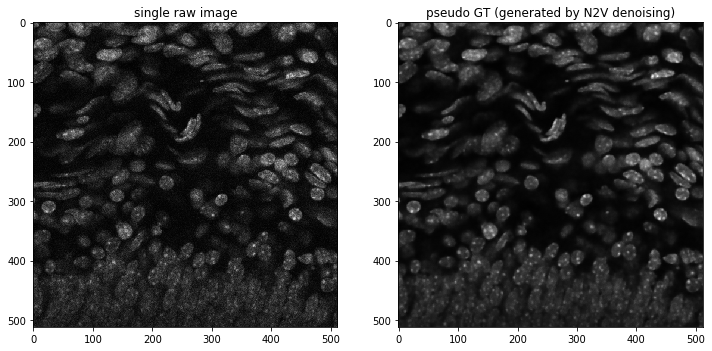

In [7]:
# In bootstrap mode, we estimate pseudo GT by using N2V denoised images.
signal = np.array(resultImgs)   
# Let's look the raw data and our pseudo ground truth signal
print(signal.shape)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 2)
plt.title(label='pseudo GT (generated by N2V denoising)')
plt.imshow(signal[0],cmap='gray')
plt.subplot(1, 2, 1)
plt.title(label='single raw image')
plt.imshow(observation[0],cmap='gray')
plt.show()

### Creating the Histogram Noise Model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a histogram based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [8]:
# We set the range of values we want to cover with our model.
# The pixel intensities in the images you want to denoise have to lie within this range.
# The dataset is clipped to values between 0 and 255.
minVal, maxVal = 2000, 22000
bins = 400

# We are creating the histogram.
# This can take a minute.
histogram = pn2v.histNoiseModel.createHistogram(bins,minVal,maxVal,observation,signal)

# Saving histogram to disc.
np.save(path+nameHistNoiseModel+'.npy', histogram)
histogramFD=histogram[0]

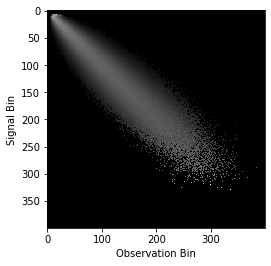

In [9]:
# Let's look at the histogram-based noise model
plt.xlabel('Observation Bin')
plt.ylabel('Signal Bin')
plt.imshow(histogramFD**0.25, cmap='gray')
plt.show()

### Creating the GMM noise model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a GMM based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [10]:
min_signal=np.percentile(signal, 0.5)
max_signal=np.percentile(signal, 99.5)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

Minimum Signal Intensity is 2687.9921862792967
Maximum Signal Intensity is 10292.440454101576


Iterating the noise model training for `n_epoch=4000` and `batchSize=25000` works the best for `Mouse Skull Nuclei` dataset. 

In [11]:
gaussianMixtureNoiseModel = pn2v.gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(min_signal = min_signal, max_signal = max_signal, path=path, weight = None, n_gaussian = n_gaussian, n_coeff = n_coeff, device = device, min_sigma = 50)
gaussianMixtureNoiseModel.train(signal, observation, batchSize = 25000, n_epochs = 4000, learning_rate = 0.1, name = nameGMMNoiseModel, lowerClip = 0.5, upperClip = 99.5)

0 19.025678634643555
100 7.5309834480285645
200 7.521834850311279
300 7.520931243896484
400 7.528710842132568
500 7.531602382659912
600 7.53032922744751
700 7.527201175689697
800 7.534379959106445
900 7.530204772949219
1000 7.526316165924072
1100 7.525769233703613
1200 7.533581256866455
1300 7.5121355056762695
1400 7.530355930328369
1500 7.519688606262207
1600 7.518554210662842
1700 7.517080307006836
1800 7.523499965667725
1900 7.523528099060059
2000 7.527632236480713
2100 7.517704963684082
2200 7.523962497711182
2300 7.524301528930664
2400 7.52598237991333
2500 7.530059814453125
2600 7.52463960647583
2700 7.536227226257324
2800 7.535784721374512
2900 7.533432483673096
3000 7.530096054077148
3100 7.525932312011719
3200 7.538338661193848
3300 7.5361552238464355
3400 7.527017116546631
3500 7.530307292938232
3600 7.51954984664917
3700 7.526674747467041
3800 7.52796745300293
3900 7.538666248321533

The trained parameters (GMMNoiseModel_mouseskullnuclei_3_2_bootstrap) is saved at location: 

### Visualizing the Histogram-based and GMM-based noise models

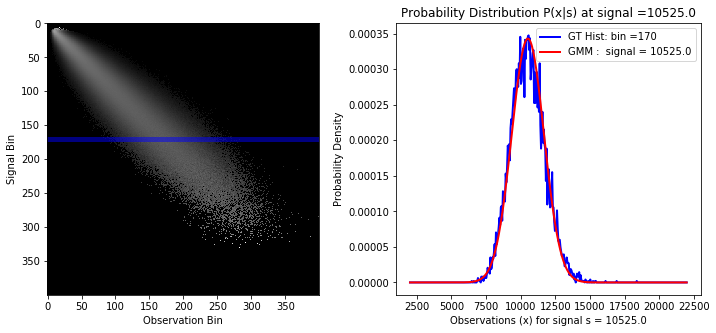

In [12]:
plotProbabilityDistribution(signalBinIndex=170, histogram=histogramFD, gaussianMixtureNoiseModel=gaussianMixtureNoiseModel, min_signal=minVal, max_signal=maxVal, n_bin= bins, device=device)